In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchinfo import summary
from tqdm import tqdm

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from pandas import read_csv

In [2]:
import random
import os

seed_value = 42

random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device
# torch.use_deterministic_algorithms(True)

'cuda'

# Loading Dataset

In [3]:
train = pd.read_csv('/kaggle/input/har-using-deep-nn/train.csv')
train.sample()

,tBodyAcc_mean_X,tBodyAcc_mean_Y,tBodyAcc_mean_Z,tBodyAcc_std_X,tBodyAcc_std_Y,tBodyAcc_std_Z,tBodyAcc_mad_X,tBodyAcc_mad_Y,tBodyAcc_mad_Z,tBodyAcc_max_X,...,angletBodyAccMeangravity,angletBodyAccJerkMeangravityMean,angletBodyGyroMeangravityMean,angletBodyGyroJerkMeangravityMean,angleXgravityMean,angleYgravityMean,angleZgravityMean,subject,Activity,ActivityName
4525,0.283203,-0.047024,-0.168986,0.384949,0.176898,-0.310332,0.381757,0.122611,-0.332984,0.465563,...,-0.034924,0.558036,0.258975,-0.854858,-0.78433,0.22296,-0.066506,22,3,WALKING_DOWNSTAIRS


In [4]:
train.shape

(7352, 564)

In [5]:
test = pd.read_csv('/kaggle/input/har-using-deep-nn/test.csv')
test.sample()

,tBodyAcc_mean_X,tBodyAcc_mean_Y,tBodyAcc_mean_Z,tBodyAcc_std_X,tBodyAcc_std_Y,tBodyAcc_std_Z,tBodyAcc_mad_X,tBodyAcc_mad_Y,tBodyAcc_mad_Z,tBodyAcc_max_X,...,angletBodyAccMeangravity,angletBodyAccJerkMeangravityMean,angletBodyGyroMeangravityMean,angletBodyGyroJerkMeangravityMean,angleXgravityMean,angleYgravityMean,angleZgravityMean,subject,Activity,ActivityName
718,0.3659,-0.031332,-0.024079,0.183421,-0.344568,-0.403268,0.09989,-0.3422,-0.412337,0.4803,...,-0.37837,-0.840289,-0.864326,0.848585,-0.960939,0.116422,-0.003858,9,3,WALKING_DOWNSTAIRS


In [6]:
test.shape

(2947, 564)

In [7]:
print('Duplicates in train = {}'.format(sum(train.duplicated())))
print('Duplicates in test = {}'.format(sum(test.duplicated())))
print('Invalid values in train = {}'.format(train.isnull().values.sum()))
print('Invalid values in test = {}'.format(test.isnull().values.sum()))

Duplicates in train = 0
Duplicates in test = 0
Invalid values in train = 0
Invalid values in test = 0


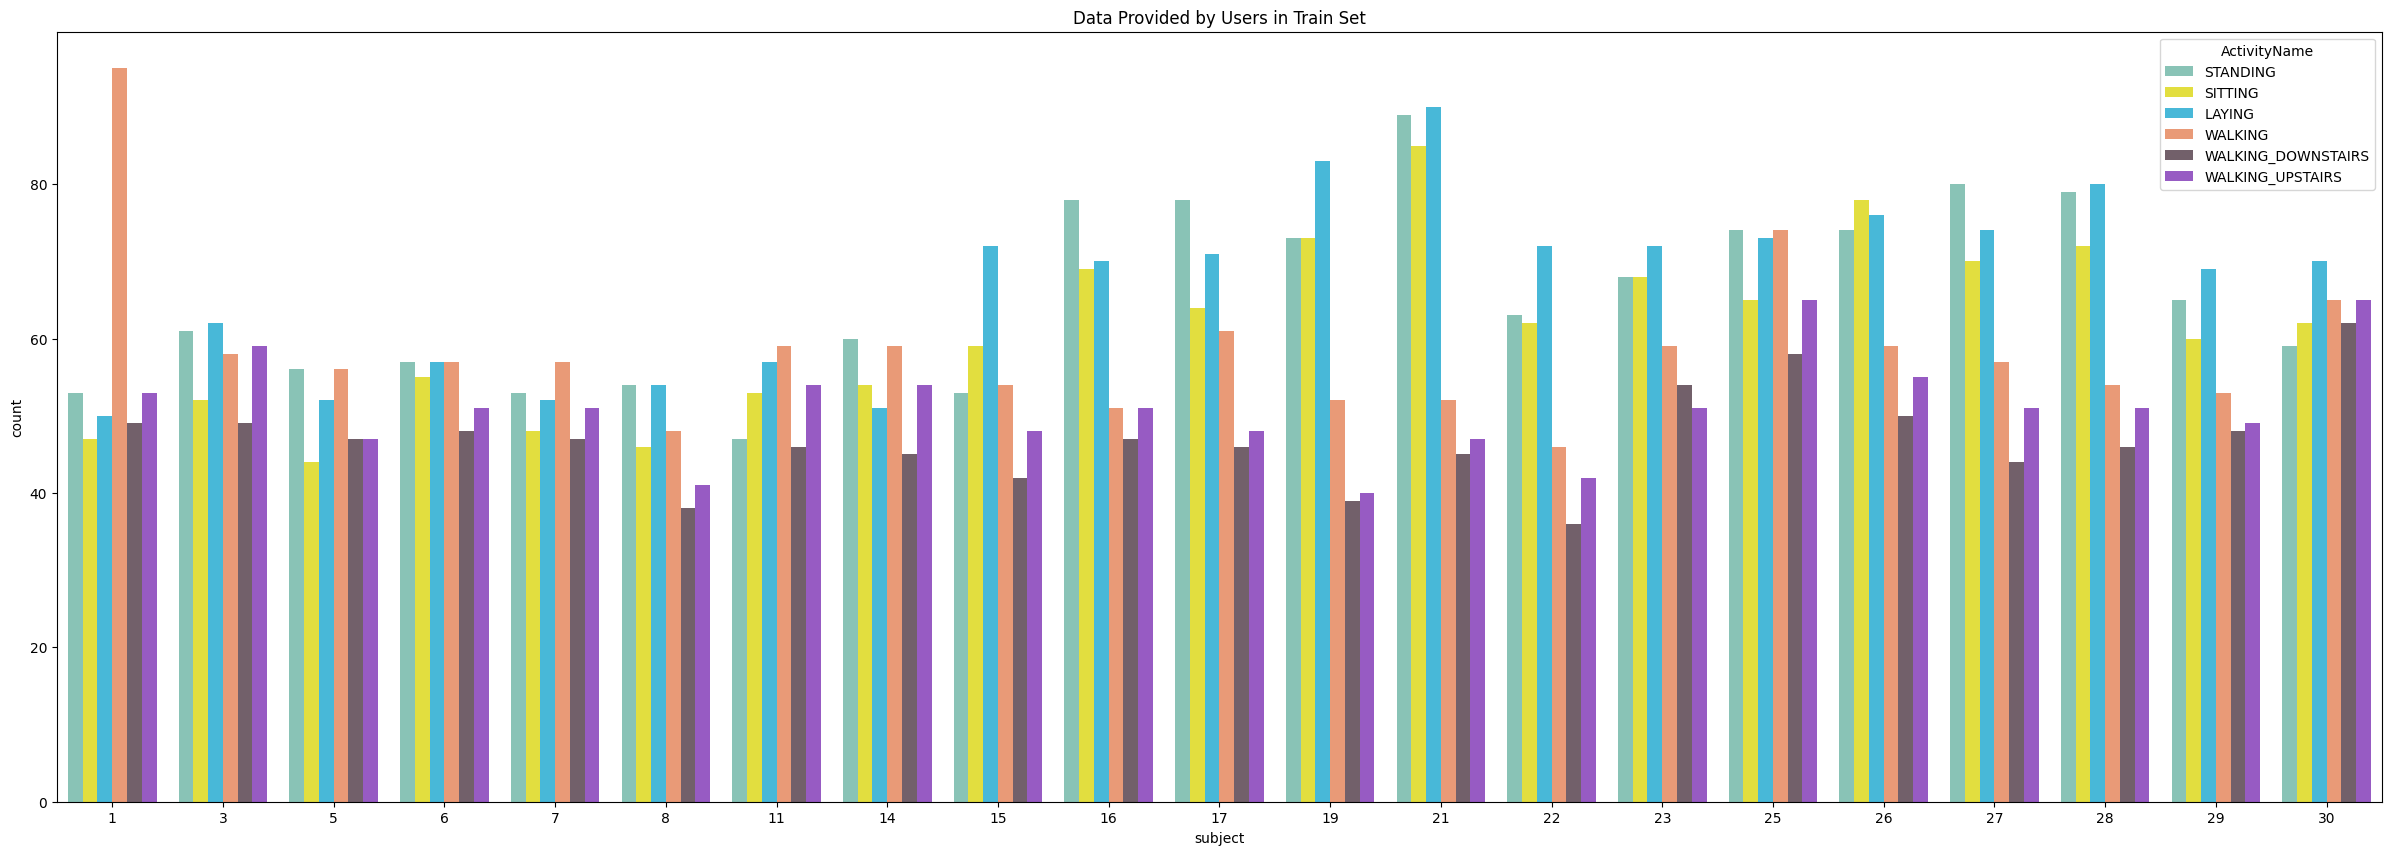

In [8]:
plt.figure(figsize=(30,10))
sns.countplot(x='subject',hue='ActivityName',palette= ["#7fcdbb","#fdf824","#30c6f0","#fc9264","#755d6b","#9a4ad4"], data = train)
plt.title('Data Provided by Users in Train Set')
plt.show()

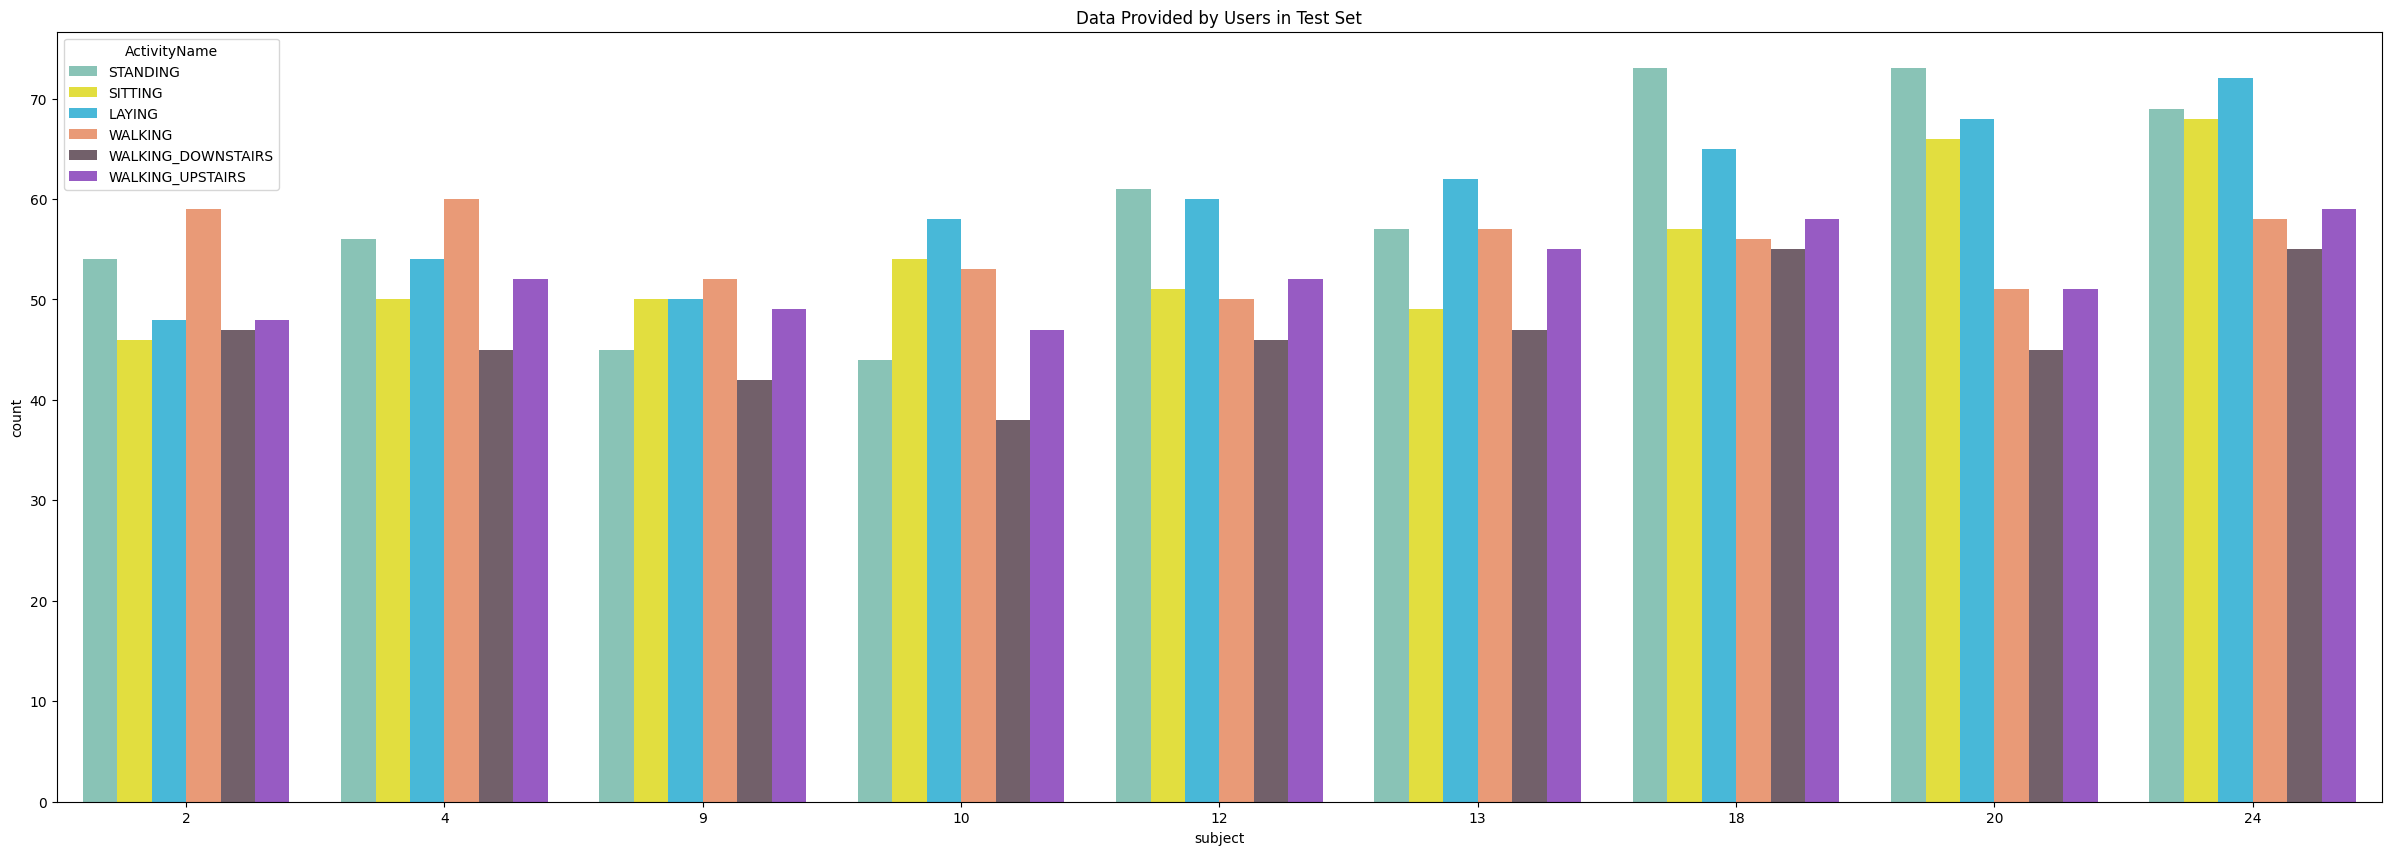

In [9]:
plt.figure(figsize=(30,10))
sns.countplot(x='subject',hue='ActivityName',palette= ["#7fcdbb","#fdf824","#30c6f0","#fc9264","#755d6b","#9a4ad4"], data = test)
plt.title('Data Provided by Users in Test Set')
plt.show()

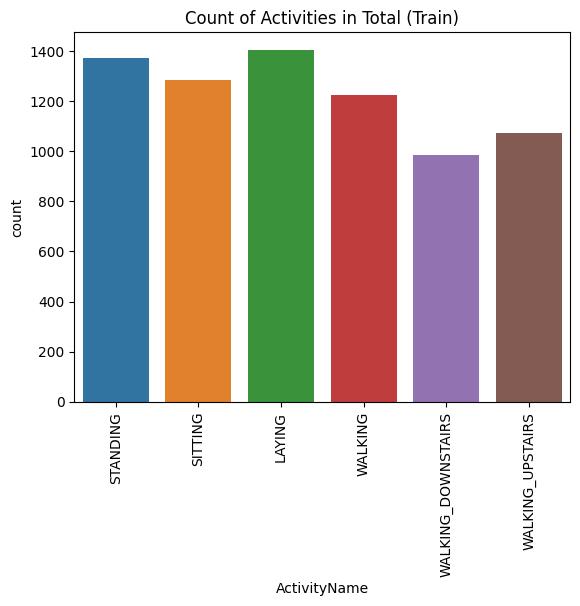

In [10]:
plt.title('Count of Activities in Total (Train)')
sns.countplot(x="ActivityName",data=train)
plt.xticks(rotation=90)
plt.show()

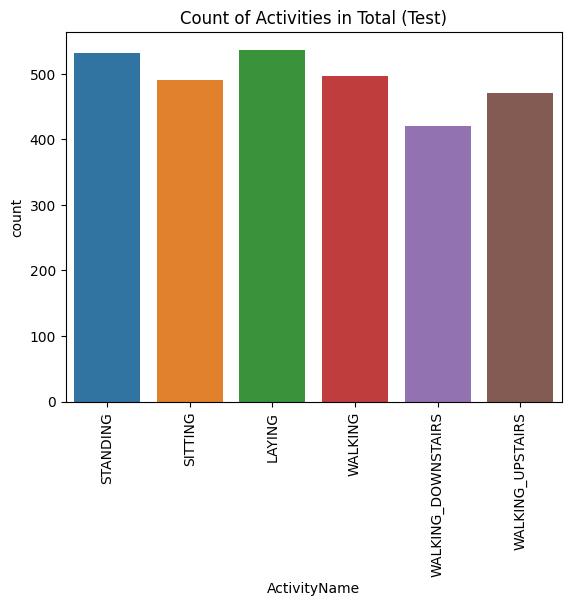

In [11]:
plt.title('Count of Activities in Total (Test)')
sns.countplot(x="ActivityName",data=test)
plt.xticks(rotation=90)
plt.show()

In [12]:
def file_load(filepath):
    df = read_csv(filepath, header=None, sep='\s+')
    return df.values

In [13]:
def train_test_append(filenames, append_before=''):
    datalist = list()
    for name in filenames:
        data = file_load(append_before + name)
        datalist.append(data)
    datalist = np.dstack(datalist)
    return datalist

In [14]:
def inertial_signals_load(group, append_before=''):
    filepath = append_before + group + '/Inertial Signals/'
    filenames = list()
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    X = train_test_append(filenames, filepath)
    y = file_load(append_before + group + '/y_'+group+'.txt')
    return X, y

In [15]:
def load_dataset(append_before=''):
    trainX, trainy = inertial_signals_load('train', append_before + '/kaggle/input/ucihar-dataset/UCI-HAR Dataset/')
    testX, testy = inertial_signals_load('test', append_before + '/kaggle/input/ucihar-dataset/UCI-HAR Dataset/')
    trainy = trainy - 1
    testy = testy - 1
    trainy = pd.get_dummies(trainy[:,0], dtype=int).values
    testy = pd.get_dummies(testy[:,0], dtype=int).values
    print(trainX.shape, trainy.shape, testX.shape, testy.shape)
    return trainX, trainy, testX, testy

In [16]:
trainX, trainy, testX, testy = load_dataset()
verbose, epochs, batch_size = 0, 100, 200
n_timesteps = trainX.shape[1]
n_features = trainX.shape[2]
n_outputs = trainy.shape[1]
# n_steps = 4
# n_length = 32
# trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
# testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features)) 
print(trainX.shape,testX.shape)

(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)
(7352, 128, 9) (2947, 128, 9)


## Setting Up the train and test loaders

In [17]:
class HARDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [66]:
train_dataset = HARDataset(trainX, trainy)
test_dataset = HARDataset(testX, testy)

BATCH = 256
train_loader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH, shuffle=False)

# Modelling

In [19]:
class AdaptiveRNN(nn.Module):
    def __init__(self, n_timesteps, n_features, n_outputs):
        super(AdaptiveRNN, self).__init__()

        # Bi-directional LSTM layer
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=128,
            batch_first=True,
            bidirectional=True
        )
        self.batch_norm = nn.BatchNorm1d(128 * 2)

        # Attention mechanism
        self.attention_dense = nn.Linear(128 * 2, 1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, n_outputs)

        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # LSTM output
        lstm_out, _ = self.lstm(x)  # lstm_out shape: (batch_size, timesteps, 128*2)
        
        batch_size, n_timesteps, n_features = lstm_out.size()
        lstm_out = lstm_out.reshape(batch_size * n_timesteps, n_features)
        lstm_out = self.batch_norm(lstm_out)
        lstm_out = lstm_out.reshape(batch_size, n_timesteps, n_features)
        
        # Attention mechanism
        attention_scores = torch.sigmoid(self.attention_dense(lstm_out))  # (batch_size, timesteps, 1)
        attention_scores = lstm_out * attention_scores  # Weighted timesteps

        # Global average pooling
        pooled = attention_scores.mean(dim=1)
        
        # Fully connected layers
        x = F.relu(self.fc1(pooled))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return F.softmax(x, dim=1)

In [20]:
# Define the model parameters
n_timesteps = 32 * 4  # 128 timesteps
n_features = 9
n_outputs = 6

# Create the model
model = AdaptiveRNN(n_timesteps=n_timesteps, n_features=n_features, n_outputs=n_outputs).to(device)
summary(model)

Layer (type:depth-idx)                   Param #
AdaptiveRNN                              --
├─LSTM: 1-1                              142,336
├─BatchNorm1d: 1-2                       512
├─Linear: 1-3                            257
├─Linear: 1-4                            32,896
├─Linear: 1-5                            8,256
├─Linear: 1-6                            390
├─Dropout: 1-7                           --
Total params: 184,647
Trainable params: 184,647
Non-trainable params: 0

In [21]:
def warmup_lr(epoch, step_size, warmup_epochs=5, gamma=0.1):
    if epoch < warmup_epochs:
        return (epoch + 1) / warmup_epochs
    
    else:
        epoch_since_warmup = epoch - warmup_epochs
        return gamma ** (epoch_since_warmup // step_size)

WARMUP_EPOCHS = 14
GAMMA = 0.1
STEP_SIZE = 20

# Loss function, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda x: warmup_lr(x, warmup_epochs=WARMUP_EPOCHS, gamma=GAMMA, step_size=STEP_SIZE))
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0 = 50, T_mult = 2, eta_min = 1e-6)

In [22]:
def train_model(model, train_loader, val_loader, epochs=20, device='cpu', early_stopping=False):
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    patience = 8
    min_delta = 1e-6
    best_loss = np.inf
    patience_counter = 0
    
    for epoch in range(epochs):
        model.train()
        train_loss, train_correct = 0.0, 0
        
        # Training phase
        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training", unit="batch") as tepoch:
            for inputs, targets in tepoch:
                inputs = inputs.to(device)
                targets = targets.to(device)
                
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item() * inputs.size(0)
                train_correct += (outputs.argmax(1) == targets.argmax(1)).sum().item()

                tepoch.set_postfix(loss=loss.item())

        scheduler.step()

        train_loss /= len(train_loader.dataset)
        train_acc = train_correct / len(train_loader.dataset)

        # Validation phase
        model.eval()
        val_loss, val_correct = 0.0, 0
        with torch.no_grad():
            with tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} - Validation", unit="batch") as vepoch:
                for inputs, targets in vepoch:
                    inputs = inputs.to(device)
                    targets = targets.to(device)
                    
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    val_loss += loss.item() * inputs.size(0)
                    val_correct += (outputs.argmax(1) == targets.argmax(1)).sum().item()

                    vepoch.set_postfix(loss=loss.item())

        val_loss /= len(val_loader.dataset)
        val_acc = val_correct / len(val_loader.dataset)

        # Save history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} - "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        if val_loss < best_loss - min_delta:
            best_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1


        if patience_counter >= patience and early_stopping:
            print("Early stopping triggered!")
            break

    return history

In [ ]:
history = train_model(model, train_loader, test_loader, epochs=150, device=device, early_stopping=False)

In [ ]:
# Plot history
def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 4))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss History')

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy History')

    plt.show()

In [ ]:
plot_history(history)

In [23]:
class TCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation_rate):
        super(TCNBlock, self).__init__()

        self.conv1 = nn.Conv1d(
            in_channels,
            out_channels,
            kernel_size,
            padding='same',
            dilation=dilation_rate
        )
        self.batch_norm = nn.BatchNorm1d(out_channels)

        # Residual connection
        if in_channels != out_channels:
            self.shortcut = nn.Conv1d(in_channels, out_channels, kernel_size=1)
        else:
            self.shortcut = None

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = self.batch_norm(out)

        shortcut = self.shortcut(x) if self.shortcut is not None else x
        return F.relu(out + shortcut)

class TCNModel(nn.Module):
    def __init__(self, n_length, n_features, n_outputs):
        super(TCNModel, self).__init__()

        self.tcn_blocks = nn.Sequential(
            TCNBlock(n_features, 64, kernel_size=3, dilation_rate=1),
            TCNBlock(64, 64, kernel_size=3, dilation_rate=2),
            TCNBlock(64, 64, kernel_size=3, dilation_rate=4),
            TCNBlock(64, 64, kernel_size=3, dilation_rate=8)
        )

        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(64, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, n_outputs)

        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Convert to (batch_size, n_features, n_length)
        x = self.tcn_blocks(x)

        x = self.global_avg_pool(x).squeeze(-1)  # Global average pooling

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return F.softmax(x, dim=1)

# Define model parameters
n_length = 128  
n_features = 9
n_outputs = 6

In [ ]:
# Instantiate model
model = TCNModel(n_length, n_features, n_outputs).to(device)
summary(model)

In [ ]:
def warmup_lr(epoch, step_size, warmup_epochs=5, gamma=0.1):
    if epoch < warmup_epochs:
        return (epoch + 1) / warmup_epochs
    
    else:
        epoch_since_warmup = epoch - warmup_epochs
        return gamma ** (epoch_since_warmup // step_size)

WARMUP_EPOCHS = 14
GAMMA = 0.1
STEP_SIZE = 20

# Loss function, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda x: warmup_lr(x, warmup_epochs=WARMUP_EPOCHS, gamma=GAMMA, step_size=STEP_SIZE))
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0 = 50, T_mult = 2, eta_min = 1e-6)

In [ ]:
def train_model(model, train_loader, val_loader, epochs=20, device='cpu', early_stopping=False):
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    patience = 8
    min_delta = 1e-6
    best_loss = np.inf
    patience_counter = 0
    
    for epoch in range(epochs):
        model.train()
        train_loss, train_correct = 0.0, 0
        
        # Training phase
        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training", unit="batch") as tepoch:
            for inputs, targets in tepoch:
                inputs = inputs.to(device)
                targets = targets.to(device)
                
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item() * inputs.size(0)
                train_correct += (outputs.argmax(1) == targets.argmax(1)).sum().item()

                tepoch.set_postfix(loss=loss.item())

        scheduler.step()

        train_loss /= len(train_loader.dataset)
        train_acc = train_correct / len(train_loader.dataset)

        # Validation phase
        model.eval()
        val_loss, val_correct = 0.0, 0
        with torch.no_grad():
            with tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} - Validation", unit="batch") as vepoch:
                for inputs, targets in vepoch:
                    inputs = inputs.to(device)
                    targets = targets.to(device)
                    
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    val_loss += loss.item() * inputs.size(0)
                    val_correct += (outputs.argmax(1) == targets.argmax(1)).sum().item()

                    vepoch.set_postfix(loss=loss.item())

        val_loss /= len(val_loader.dataset)
        val_acc = val_correct / len(val_loader.dataset)

        # Save history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} - "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        if val_loss < best_loss - min_delta:
            best_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1


        if patience_counter >= patience and early_stopping:
            print("Early stopping triggered!")
            break

    return history

In [ ]:
history = train_model(model, train_loader, test_loader, epochs=120, device=device, early_stopping=False)

In [ ]:
# Plot history
def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 4))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss History')

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy History')

    plt.show()

In [ ]:
plot_history(history)

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=8):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.max_pool = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Conv1d(in_channels, in_channels // reduction_ratio, kernel_size=1)
        self.fc2 = nn.Conv1d(in_channels // reduction_ratio, in_channels, kernel_size=1)

    def forward(self, x):
        avg_pool = self.avg_pool(x)
        max_pool = self.max_pool(x)

        avg_out = F.relu(self.fc1(avg_pool))
        avg_out = self.fc2(avg_out)

        max_out = F.relu(self.fc1(max_pool))
        max_out = self.fc2(max_out)

        out = avg_out + max_out
        return torch.sigmoid(out) * x  # Channel attention applied

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv1d(2, 1, kernel_size=kernel_size, padding=kernel_size//2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_pool = torch.mean(x, dim=1, keepdim=True)
        max_pool, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_pool, max_pool], dim=1)  # Concatenate along channel dimension
        out = self.conv(x_cat)
        return self.sigmoid(out) * x  # Spatial attention applied

class CBAMBlock(nn.Module):
    def __init__(self, in_channels):
        super(CBAMBlock, self).__init__()
        self.channel_attention = ChannelAttention(in_channels)
        self.spatial_attention = SpatialAttention()

    def forward(self, x):
        x = self.channel_attention(x)
        x = self.spatial_attention(x)
        return x

class TCNWithCBAM(nn.Module):
    def __init__(self, n_length, n_features, n_outputs):
        super(TCNWithCBAM, self).__init__()

        self.tcn_blocks = nn.Sequential(
            TCNBlock(n_features, 64, kernel_size=3, dilation_rate=1),
            TCNBlock(64, 64, kernel_size=3, dilation_rate=2),
            TCNBlock(64, 64, kernel_size=3, dilation_rate=4),
            TCNBlock(64, 64, kernel_size=3, dilation_rate=8)
        ) # (batch_size, out_channels, n_length)

        self.cbam_block = CBAMBlock(64)

        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(64, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, n_outputs)

        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Convert to (batch_size, n_features, n_length)
        x = self.tcn_blocks(x)

        # Apply CBAM
        x = self.cbam_block(x)

        x = self.global_avg_pool(x).squeeze(-1)  # Global average pooling

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return F.softmax(x, dim=1)

# Define model parameters
n_length = 128  
n_features = 9
n_outputs = 6

In [81]:
model = TCNWithCBAM(n_length, n_features, n_outputs).to(device)
summary(model)

Layer (type:depth-idx)                   Param #
TCNWithCBAM                              --
├─Sequential: 1-1                        --
│    └─TCNBlock: 2-1                     --
│    │    └─Conv1d: 3-1                  1,792
│    │    └─BatchNorm1d: 3-2             128
│    │    └─Conv1d: 3-3                  640
│    └─TCNBlock: 2-2                     --
│    │    └─Conv1d: 3-4                  12,352
│    │    └─BatchNorm1d: 3-5             128
│    └─TCNBlock: 2-3                     --
│    │    └─Conv1d: 3-6                  12,352
│    │    └─BatchNorm1d: 3-7             128
│    └─TCNBlock: 2-4                     --
│    │    └─Conv1d: 3-8                  12,352
│    │    └─BatchNorm1d: 3-9             128
├─CBAMBlock: 1-2                         --
│    └─ChannelAttention: 2-5             --
│    │    └─AdaptiveAvgPool1d: 3-10      --
│    │    └─AdaptiveMaxPool1d: 3-11      --
│    │    └─Conv1d: 3-12                 520
│    │    └─Conv1d: 3-13                 576
│    

In [82]:
def warmup_lr(epoch, step_size, warmup_epochs=5, gamma=0.1):
    if epoch < warmup_epochs:
        return (epoch + 1) / warmup_epochs
    
    else:
        epoch_since_warmup = epoch - warmup_epochs
        return gamma ** (epoch_since_warmup // step_size)

WARMUP_EPOCHS = 14
GAMMA = 0.1
STEP_SIZE = 20

# Loss function, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda x: warmup_lr(x, warmup_epochs=WARMUP_EPOCHS, gamma=GAMMA, step_size=STEP_SIZE))
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 50, eta_min = 1e-6)

In [83]:
def train_model(model, train_loader, val_loader, epochs=20, device='cpu', early_stopping=False):
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    patience = 20
    min_delta = 1e-6
    best_loss = np.inf
    patience_counter = 0
    
    for epoch in range(epochs):
        model.train()
        train_loss, train_correct = 0.0, 0
        
        # Training phase
        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training", unit="batch") as tepoch:
            for inputs, targets in tepoch:
                inputs = inputs.to(device)
                targets = targets.to(device)
                
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item() * inputs.size(0)
                train_correct += (outputs.argmax(1) == targets.argmax(1)).sum().item()

                tepoch.set_postfix(loss=loss.item())

        scheduler.step()

        train_loss /= len(train_loader.dataset)
        train_acc = train_correct / len(train_loader.dataset)

        # Validation phase
        model.eval()
        val_loss, val_correct = 0.0, 0
        with torch.no_grad():
            with tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} - Validation", unit="batch") as vepoch:
                for inputs, targets in vepoch:
                    inputs = inputs.to(device)
                    targets = targets.to(device)
                    
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    val_loss += loss.item() * inputs.size(0)
                    val_correct += (outputs.argmax(1) == targets.argmax(1)).sum().item()

                    vepoch.set_postfix(loss=loss.item())

        val_loss /= len(val_loader.dataset)
        val_acc = val_correct / len(val_loader.dataset)

        # Save history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} - "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        if val_loss < best_loss - min_delta:
            best_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1


        if patience_counter >= patience and early_stopping and epoch > 100:
            print("Early stopping triggered!")
            break

    return history

In [84]:
history = train_model(model, train_loader, test_loader, epochs=150, device=device, early_stopping=True)

Epoch 1/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 158.82batch/s, loss=1.71]


Epoch 1/150 - Train Loss: 1.7630, Train Acc: 0.3221 - Val Loss: 1.7381, Val Acc: 0.5144


Epoch 2/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 157.79batch/s, loss=1.39]


Epoch 2/150 - Train Loss: 1.5160, Train Acc: 0.5499 - Val Loss: 1.4180, Val Acc: 0.6322


Epoch 3/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 156.47batch/s, loss=1.07]


Epoch 3/150 - Train Loss: 1.2384, Train Acc: 0.8369 - Val Loss: 1.2181, Val Acc: 0.8643


Epoch 4/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 167.83batch/s, loss=1.04]


Epoch 4/150 - Train Loss: 1.1201, Train Acc: 0.9465 - Val Loss: 1.1540, Val Acc: 0.8901


Epoch 5/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 167.13batch/s, loss=1.04]


Epoch 5/150 - Train Loss: 1.0917, Train Acc: 0.9528 - Val Loss: 1.1451, Val Acc: 0.8979


Epoch 6/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 156.35batch/s, loss=1.04]


Epoch 6/150 - Train Loss: 1.0852, Train Acc: 0.9592 - Val Loss: 1.1553, Val Acc: 0.8884


Epoch 7/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 166.38batch/s, loss=1.04]


Epoch 7/150 - Train Loss: 1.0849, Train Acc: 0.9587 - Val Loss: 1.1417, Val Acc: 0.9006


Epoch 8/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 164.01batch/s, loss=1.04]


Epoch 8/150 - Train Loss: 1.0851, Train Acc: 0.9588 - Val Loss: 1.1457, Val Acc: 0.8972


Epoch 9/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 169.68batch/s, loss=1.04]


Epoch 9/150 - Train Loss: 1.0844, Train Acc: 0.9591 - Val Loss: 1.1444, Val Acc: 0.8962


Epoch 10/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 170.48batch/s, loss=1.04]


Epoch 10/150 - Train Loss: 1.0828, Train Acc: 0.9608 - Val Loss: 1.1417, Val Acc: 0.9006


Epoch 11/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 168.03batch/s, loss=1.04]


Epoch 11/150 - Train Loss: 1.0837, Train Acc: 0.9601 - Val Loss: 1.1365, Val Acc: 0.9070


Epoch 12/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 169.06batch/s, loss=1.04]


Epoch 12/150 - Train Loss: 1.0808, Train Acc: 0.9633 - Val Loss: 1.1424, Val Acc: 0.9002


Epoch 13/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 166.28batch/s, loss=1.04]


Epoch 13/150 - Train Loss: 1.0814, Train Acc: 0.9625 - Val Loss: 1.1413, Val Acc: 0.9019


Epoch 14/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 156.15batch/s, loss=1.04]


Epoch 14/150 - Train Loss: 1.0823, Train Acc: 0.9614 - Val Loss: 1.1392, Val Acc: 0.9040


Epoch 15/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 167.66batch/s, loss=1.04]


Epoch 15/150 - Train Loss: 1.0817, Train Acc: 0.9622 - Val Loss: 1.1340, Val Acc: 0.9101


Epoch 16/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 167.90batch/s, loss=1.04]


Epoch 16/150 - Train Loss: 1.0772, Train Acc: 0.9667 - Val Loss: 1.1291, Val Acc: 0.9135


Epoch 17/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 169.24batch/s, loss=1.04]


Epoch 17/150 - Train Loss: 1.0766, Train Acc: 0.9669 - Val Loss: 1.1226, Val Acc: 0.9209


Epoch 18/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 167.15batch/s, loss=1.04]


Epoch 18/150 - Train Loss: 1.0762, Train Acc: 0.9678 - Val Loss: 1.1212, Val Acc: 0.9220


Epoch 19/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 168.17batch/s, loss=1.04]


Epoch 19/150 - Train Loss: 1.0778, Train Acc: 0.9664 - Val Loss: 1.1286, Val Acc: 0.9148


Epoch 20/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 170.83batch/s, loss=1.04]


Epoch 20/150 - Train Loss: 1.0774, Train Acc: 0.9661 - Val Loss: 1.1298, Val Acc: 0.9131


Epoch 21/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 165.87batch/s, loss=1.04]


Epoch 21/150 - Train Loss: 1.0754, Train Acc: 0.9682 - Val Loss: 1.1351, Val Acc: 0.9070


Epoch 22/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 165.38batch/s, loss=1.04]


Epoch 22/150 - Train Loss: 1.0746, Train Acc: 0.9694 - Val Loss: 1.1181, Val Acc: 0.9253


Epoch 23/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 169.57batch/s, loss=1.04]


Epoch 23/150 - Train Loss: 1.0742, Train Acc: 0.9691 - Val Loss: 1.1171, Val Acc: 0.9260


Epoch 24/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 158.54batch/s, loss=1.04]


Epoch 24/150 - Train Loss: 1.0750, Train Acc: 0.9684 - Val Loss: 1.1136, Val Acc: 0.9298


Epoch 25/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 166.61batch/s, loss=1.04]


Epoch 25/150 - Train Loss: 1.0745, Train Acc: 0.9687 - Val Loss: 1.1214, Val Acc: 0.9209


Epoch 26/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 169.48batch/s, loss=1.04]


Epoch 26/150 - Train Loss: 1.0740, Train Acc: 0.9693 - Val Loss: 1.1263, Val Acc: 0.9162


Epoch 27/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 157.68batch/s, loss=1.04]


Epoch 27/150 - Train Loss: 1.0748, Train Acc: 0.9687 - Val Loss: 1.1287, Val Acc: 0.9148


Epoch 28/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 154.74batch/s, loss=1.04]


Epoch 28/150 - Train Loss: 1.0747, Train Acc: 0.9691 - Val Loss: 1.1254, Val Acc: 0.9165


Epoch 29/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 166.89batch/s, loss=1.04]


Epoch 29/150 - Train Loss: 1.0736, Train Acc: 0.9698 - Val Loss: 1.1208, Val Acc: 0.9230


Epoch 30/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 161.83batch/s, loss=1.04]


Epoch 30/150 - Train Loss: 1.0732, Train Acc: 0.9708 - Val Loss: 1.1183, Val Acc: 0.9250


Epoch 31/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 163.73batch/s, loss=1.04]


Epoch 31/150 - Train Loss: 1.0735, Train Acc: 0.9705 - Val Loss: 1.1174, Val Acc: 0.9257


Epoch 32/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 165.54batch/s, loss=1.04]


Epoch 32/150 - Train Loss: 1.0721, Train Acc: 0.9716 - Val Loss: 1.1219, Val Acc: 0.9213


Epoch 33/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 166.83batch/s, loss=1.04]


Epoch 33/150 - Train Loss: 1.0711, Train Acc: 0.9725 - Val Loss: 1.1288, Val Acc: 0.9148


Epoch 34/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 163.65batch/s, loss=1.04]


Epoch 34/150 - Train Loss: 1.0716, Train Acc: 0.9721 - Val Loss: 1.1239, Val Acc: 0.9199


Epoch 35/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 166.86batch/s, loss=1.04]


Epoch 35/150 - Train Loss: 1.0709, Train Acc: 0.9725 - Val Loss: 1.1246, Val Acc: 0.9196


Epoch 36/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 154.07batch/s, loss=1.04]


Epoch 36/150 - Train Loss: 1.0723, Train Acc: 0.9713 - Val Loss: 1.1284, Val Acc: 0.9148


Epoch 37/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 153.36batch/s, loss=1.04]


Epoch 37/150 - Train Loss: 1.0704, Train Acc: 0.9731 - Val Loss: 1.1221, Val Acc: 0.9216


Epoch 38/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 162.39batch/s, loss=1.04]


Epoch 38/150 - Train Loss: 1.0687, Train Acc: 0.9751 - Val Loss: 1.1224, Val Acc: 0.9209


Epoch 39/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 163.13batch/s, loss=1.04]


Epoch 39/150 - Train Loss: 1.0713, Train Acc: 0.9723 - Val Loss: 1.1199, Val Acc: 0.9243


Epoch 40/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 161.02batch/s, loss=1.04]


Epoch 40/150 - Train Loss: 1.0683, Train Acc: 0.9755 - Val Loss: 1.1213, Val Acc: 0.9220


Epoch 41/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 154.38batch/s, loss=1.04]


Epoch 41/150 - Train Loss: 1.0689, Train Acc: 0.9747 - Val Loss: 1.1230, Val Acc: 0.9203


Epoch 42/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 163.43batch/s, loss=1.04]


Epoch 42/150 - Train Loss: 1.0688, Train Acc: 0.9747 - Val Loss: 1.1226, Val Acc: 0.9203


Epoch 43/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 167.24batch/s, loss=1.04]


Epoch 43/150 - Train Loss: 1.0675, Train Acc: 0.9762 - Val Loss: 1.1214, Val Acc: 0.9213


Epoch 44/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 167.25batch/s, loss=1.04]


Epoch 44/150 - Train Loss: 1.0680, Train Acc: 0.9759 - Val Loss: 1.1189, Val Acc: 0.9240


Epoch 45/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 168.09batch/s, loss=1.04]


Epoch 45/150 - Train Loss: 1.0676, Train Acc: 0.9763 - Val Loss: 1.1197, Val Acc: 0.9247


Epoch 46/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 167.27batch/s, loss=1.04]


Epoch 46/150 - Train Loss: 1.0682, Train Acc: 0.9755 - Val Loss: 1.1204, Val Acc: 0.9220


Epoch 47/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 165.40batch/s, loss=1.04]


Epoch 47/150 - Train Loss: 1.0679, Train Acc: 0.9758 - Val Loss: 1.1211, Val Acc: 0.9220


Epoch 48/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 169.51batch/s, loss=1.04]


Epoch 48/150 - Train Loss: 1.0678, Train Acc: 0.9758 - Val Loss: 1.1190, Val Acc: 0.9247


Epoch 49/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 155.29batch/s, loss=1.04]


Epoch 49/150 - Train Loss: 1.0678, Train Acc: 0.9758 - Val Loss: 1.1194, Val Acc: 0.9230


Epoch 50/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 168.80batch/s, loss=1.04]


Epoch 50/150 - Train Loss: 1.0671, Train Acc: 0.9761 - Val Loss: 1.1210, Val Acc: 0.9216


Epoch 51/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 166.30batch/s, loss=1.04]


Epoch 51/150 - Train Loss: 1.0670, Train Acc: 0.9766 - Val Loss: 1.1203, Val Acc: 0.9233


Epoch 52/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 167.63batch/s, loss=1.04]


Epoch 52/150 - Train Loss: 1.0676, Train Acc: 0.9761 - Val Loss: 1.1190, Val Acc: 0.9240


Epoch 53/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 171.74batch/s, loss=1.04]


Epoch 53/150 - Train Loss: 1.0676, Train Acc: 0.9759 - Val Loss: 1.1191, Val Acc: 0.9237


Epoch 54/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 171.13batch/s, loss=1.04]


Epoch 54/150 - Train Loss: 1.0669, Train Acc: 0.9766 - Val Loss: 1.1183, Val Acc: 0.9253


Epoch 55/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 155.38batch/s, loss=1.04]


Epoch 55/150 - Train Loss: 1.0675, Train Acc: 0.9759 - Val Loss: 1.1190, Val Acc: 0.9243


Epoch 56/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 165.20batch/s, loss=1.04]


Epoch 56/150 - Train Loss: 1.0674, Train Acc: 0.9762 - Val Loss: 1.1197, Val Acc: 0.9237


Epoch 57/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 155.77batch/s, loss=1.04]


Epoch 57/150 - Train Loss: 1.0676, Train Acc: 0.9761 - Val Loss: 1.1214, Val Acc: 0.9216


Epoch 58/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 169.13batch/s, loss=1.04]


Epoch 58/150 - Train Loss: 1.0656, Train Acc: 0.9781 - Val Loss: 1.1199, Val Acc: 0.9233


Epoch 59/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 155.55batch/s, loss=1.04]


Epoch 59/150 - Train Loss: 1.0684, Train Acc: 0.9751 - Val Loss: 1.1176, Val Acc: 0.9247


Epoch 60/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 156.71batch/s, loss=1.04]


Epoch 60/150 - Train Loss: 1.0670, Train Acc: 0.9770 - Val Loss: 1.1195, Val Acc: 0.9237


Epoch 61/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 169.33batch/s, loss=1.04]


Epoch 61/150 - Train Loss: 1.0668, Train Acc: 0.9767 - Val Loss: 1.1197, Val Acc: 0.9237


Epoch 62/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 168.69batch/s, loss=1.04]


Epoch 62/150 - Train Loss: 1.0674, Train Acc: 0.9765 - Val Loss: 1.1207, Val Acc: 0.9233


Epoch 63/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 156.60batch/s, loss=1.04]


Epoch 63/150 - Train Loss: 1.0667, Train Acc: 0.9770 - Val Loss: 1.1206, Val Acc: 0.9223


Epoch 64/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 166.43batch/s, loss=1.04]


Epoch 64/150 - Train Loss: 1.0667, Train Acc: 0.9770 - Val Loss: 1.1215, Val Acc: 0.9230


Epoch 65/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 163.02batch/s, loss=1.04]


Epoch 65/150 - Train Loss: 1.0667, Train Acc: 0.9771 - Val Loss: 1.1228, Val Acc: 0.9203


Epoch 66/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 165.32batch/s, loss=1.04]


Epoch 66/150 - Train Loss: 1.0664, Train Acc: 0.9776 - Val Loss: 1.1215, Val Acc: 0.9220


Epoch 67/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 166.95batch/s, loss=1.04]


Epoch 67/150 - Train Loss: 1.0703, Train Acc: 0.9736 - Val Loss: 1.1286, Val Acc: 0.9141


Epoch 68/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 159.59batch/s, loss=1.04]


Epoch 68/150 - Train Loss: 1.0681, Train Acc: 0.9752 - Val Loss: 1.1229, Val Acc: 0.9216


Epoch 69/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 158.93batch/s, loss=1.04]


Epoch 69/150 - Train Loss: 1.0683, Train Acc: 0.9750 - Val Loss: 1.1206, Val Acc: 0.9223


Epoch 70/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 166.10batch/s, loss=1.04]


Epoch 70/150 - Train Loss: 1.0683, Train Acc: 0.9754 - Val Loss: 1.1230, Val Acc: 0.9192


Epoch 71/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 157.37batch/s, loss=1.04]


Epoch 71/150 - Train Loss: 1.0699, Train Acc: 0.9736 - Val Loss: 1.1236, Val Acc: 0.9199


Epoch 72/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 156.68batch/s, loss=1.04]


Epoch 72/150 - Train Loss: 1.0689, Train Acc: 0.9744 - Val Loss: 1.1226, Val Acc: 0.9206


Epoch 73/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 144.20batch/s, loss=1.04]


Epoch 73/150 - Train Loss: 1.0706, Train Acc: 0.9731 - Val Loss: 1.1267, Val Acc: 0.9162


Epoch 74/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 163.77batch/s, loss=1.04]


Epoch 74/150 - Train Loss: 1.0689, Train Acc: 0.9750 - Val Loss: 1.1249, Val Acc: 0.9192


Epoch 75/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 163.07batch/s, loss=1.04]


Epoch 75/150 - Train Loss: 1.0692, Train Acc: 0.9743 - Val Loss: 1.1264, Val Acc: 0.9172


Epoch 76/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 165.95batch/s, loss=1.04]


Epoch 76/150 - Train Loss: 1.0703, Train Acc: 0.9732 - Val Loss: 1.1209, Val Acc: 0.9230


Epoch 77/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 169.77batch/s, loss=1.04]


Epoch 77/150 - Train Loss: 1.0692, Train Acc: 0.9746 - Val Loss: 1.1212, Val Acc: 0.9223


Epoch 78/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 159.72batch/s, loss=1.04]


Epoch 78/150 - Train Loss: 1.0693, Train Acc: 0.9742 - Val Loss: 1.1231, Val Acc: 0.9196


Epoch 79/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 157.46batch/s, loss=1.04]


Epoch 79/150 - Train Loss: 1.0702, Train Acc: 0.9731 - Val Loss: 1.1242, Val Acc: 0.9192


Epoch 80/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 155.90batch/s, loss=1.04]


Epoch 80/150 - Train Loss: 1.0701, Train Acc: 0.9732 - Val Loss: 1.1184, Val Acc: 0.9257


Epoch 81/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 165.02batch/s, loss=1.04]


Epoch 81/150 - Train Loss: 1.0694, Train Acc: 0.9747 - Val Loss: 1.1136, Val Acc: 0.9301


Epoch 82/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 168.67batch/s, loss=1.04]


Epoch 82/150 - Train Loss: 1.0667, Train Acc: 0.9769 - Val Loss: 1.1174, Val Acc: 0.9264


Epoch 83/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 153.89batch/s, loss=1.04]


Epoch 83/150 - Train Loss: 1.0694, Train Acc: 0.9740 - Val Loss: 1.1230, Val Acc: 0.9209


Epoch 84/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 156.57batch/s, loss=1.04]


Epoch 84/150 - Train Loss: 1.0719, Train Acc: 0.9721 - Val Loss: 1.1171, Val Acc: 0.9270


Epoch 85/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 168.13batch/s, loss=1.04]


Epoch 85/150 - Train Loss: 1.0708, Train Acc: 0.9731 - Val Loss: 1.1088, Val Acc: 0.9345


Epoch 86/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 155.00batch/s, loss=1.04]


Epoch 86/150 - Train Loss: 1.0684, Train Acc: 0.9755 - Val Loss: 1.1277, Val Acc: 0.9141


Epoch 87/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 167.08batch/s, loss=1.04]


Epoch 87/150 - Train Loss: 1.0673, Train Acc: 0.9766 - Val Loss: 1.1142, Val Acc: 0.9284


Epoch 88/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 172.20batch/s, loss=1.04]


Epoch 88/150 - Train Loss: 1.0734, Train Acc: 0.9701 - Val Loss: 1.1430, Val Acc: 0.9006


Epoch 89/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 144.23batch/s, loss=1.04]


Epoch 89/150 - Train Loss: 1.0736, Train Acc: 0.9701 - Val Loss: 1.1174, Val Acc: 0.9264


Epoch 90/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 166.21batch/s, loss=1.04]


Epoch 90/150 - Train Loss: 1.0690, Train Acc: 0.9744 - Val Loss: 1.1099, Val Acc: 0.9342


Epoch 91/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 155.34batch/s, loss=1.04]


Epoch 91/150 - Train Loss: 1.0701, Train Acc: 0.9737 - Val Loss: 1.1087, Val Acc: 0.9355


Epoch 92/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 168.59batch/s, loss=1.04]


Epoch 92/150 - Train Loss: 1.0737, Train Acc: 0.9699 - Val Loss: 1.1249, Val Acc: 0.9189


Epoch 93/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 161.19batch/s, loss=1.04]


Epoch 93/150 - Train Loss: 1.0709, Train Acc: 0.9725 - Val Loss: 1.1248, Val Acc: 0.9189


Epoch 94/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 156.45batch/s, loss=1.04]


Epoch 94/150 - Train Loss: 1.0685, Train Acc: 0.9754 - Val Loss: 1.1358, Val Acc: 0.9077


Epoch 95/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 159.53batch/s, loss=1.04]


Epoch 95/150 - Train Loss: 1.0753, Train Acc: 0.9684 - Val Loss: 1.1269, Val Acc: 0.9158


Epoch 96/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 158.23batch/s, loss=1.04]


Epoch 96/150 - Train Loss: 1.0732, Train Acc: 0.9703 - Val Loss: 1.1212, Val Acc: 0.9213


Epoch 97/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 169.40batch/s, loss=1.04]


Epoch 97/150 - Train Loss: 1.0723, Train Acc: 0.9714 - Val Loss: 1.1216, Val Acc: 0.9206


Epoch 98/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 162.61batch/s, loss=1.04]


Epoch 98/150 - Train Loss: 1.0719, Train Acc: 0.9720 - Val Loss: 1.1194, Val Acc: 0.9240


Epoch 99/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 166.56batch/s, loss=1.04]


Epoch 99/150 - Train Loss: 1.0674, Train Acc: 0.9763 - Val Loss: 1.1221, Val Acc: 0.9203


Epoch 100/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 166.47batch/s, loss=1.04]


Epoch 100/150 - Train Loss: 1.0718, Train Acc: 0.9717 - Val Loss: 1.1210, Val Acc: 0.9223


Epoch 101/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 167.48batch/s, loss=1.04]


Epoch 101/150 - Train Loss: 1.0675, Train Acc: 0.9766 - Val Loss: 1.1237, Val Acc: 0.9209


Epoch 102/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 170.98batch/s, loss=1.04]


Epoch 102/150 - Train Loss: 1.0669, Train Acc: 0.9767 - Val Loss: 1.1199, Val Acc: 0.9237


Epoch 103/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 153.33batch/s, loss=1.04]


Epoch 103/150 - Train Loss: 1.0673, Train Acc: 0.9765 - Val Loss: 1.1252, Val Acc: 0.9172


Epoch 104/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 169.33batch/s, loss=1.04]


Epoch 104/150 - Train Loss: 1.0717, Train Acc: 0.9723 - Val Loss: 1.1305, Val Acc: 0.9125


Epoch 105/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 155.30batch/s, loss=1.04]


Epoch 105/150 - Train Loss: 1.0725, Train Acc: 0.9709 - Val Loss: 1.1500, Val Acc: 0.8935


Epoch 106/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 165.05batch/s, loss=1.04]


Epoch 106/150 - Train Loss: 1.0727, Train Acc: 0.9706 - Val Loss: 1.1592, Val Acc: 0.8843


Epoch 107/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 166.18batch/s, loss=1.04]


Epoch 107/150 - Train Loss: 1.0770, Train Acc: 0.9671 - Val Loss: 1.1476, Val Acc: 0.8962


Epoch 108/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 160.90batch/s, loss=1.04]


Epoch 108/150 - Train Loss: 1.0711, Train Acc: 0.9728 - Val Loss: 1.1216, Val Acc: 0.9223


Epoch 109/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 170.38batch/s, loss=1.04]


Epoch 109/150 - Train Loss: 1.0699, Train Acc: 0.9736 - Val Loss: 1.1258, Val Acc: 0.9169


Epoch 110/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 171.50batch/s, loss=1.04]


Epoch 110/150 - Train Loss: 1.0727, Train Acc: 0.9708 - Val Loss: 1.1113, Val Acc: 0.9321


Epoch 111/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 169.16batch/s, loss=1.04]

Epoch 111/150 - Train Loss: 1.0725, Train Acc: 0.9710 - Val Loss: 1.1119, Val Acc: 0.9315
Early stopping triggered!


In [85]:
# Plot history
def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 4))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss History')

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy History')

    plt.show()

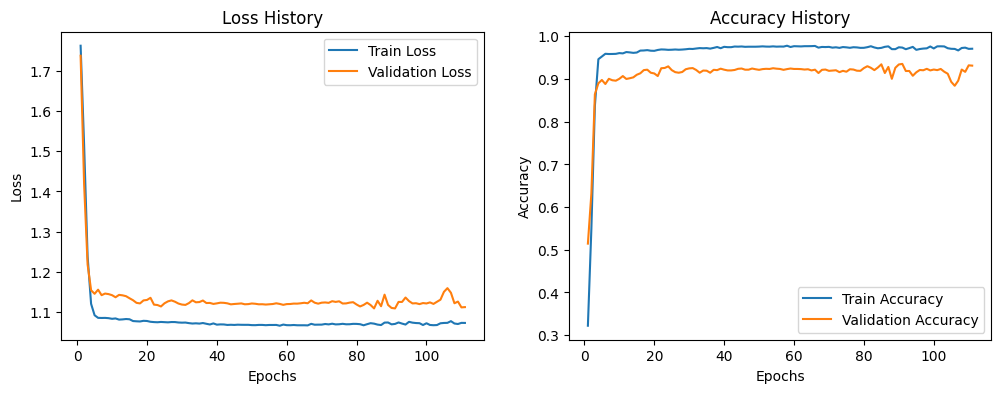

In [86]:
plot_history(history)